In [1]:
import os
import ROOT
import numpy as np
import pandas as pd


from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Hist1d, Histdd

import scipy.integrate as sp_int
from scipy.optimize import curve_fit
import scipy.stats as sps
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'
#see the AP(copy) and save!!!!! the fit parameters (res)

/home/cristian/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/cristian/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
path = "/home/cristian/Suxess_files/data/run4/gas/ap180103/"
path_CSV="/home/cristian/Suxess_files/data/run4/"
#board=0
#channel=3
os.listdir(path)

['processed_wf3_Board1_AP_LED_2.60V.root',
 'processed_wf0_Board1_AP_LED_2.45V.root',
 'processed_wf1_Board0_AP_LED_2.325V.root',
 'processed_wf0_Board0_AP_LED_2.41V.root',
 'processed_wf1_Board1_AP_LED_2.325V.root',
 'processed_wf3_Board0_AP_LED_2.45V.root',
 'processed_wf4_Board1_AP_LED_2.51V.root',
 'AP_figs',
 'processed_wf4_Board0_AP_LED_2.45V.root',
 'processed_wf5_Board0_AP_LED_2.41V.root',
 'processed_wf2_Board0_AP_LED_2.325V.root',
 'processed_wf2_Board1_AP_LED_2.35V.root',
 'processed_wf6_Board1_AP_LED_2.57V.root',
 'processed_wf5_Board1_AP_LED_2.45V.root']

In [3]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [4]:
illum_pe = []

def process_ap_file(filename):
    file = ROOT.TFile(filename)
    tree = file.Get('T1')

    pos = []
    area = []
    #entropy = []
    height = []
    width50 = []
    evtnb =[]
    for event in tqdm(file.Get('T1')):
        if len(event.Position)>0:
            for p in event.Position:
                pos.append(p)
        if len(event.Area)>0:        
            for a in event.Area:
                area.append(a)
        #for e in event.Entropy:
          #  entropy.append(e)
        if len(event.Height)>0:
            for h in event.Height:
                height.append(h)
        if len(event.Width50)>0:
            for w in event.Width50:
                width50.append(w)
        #for ev in event.Evtnb:
            #evtnb.append(ev)not the same lenght of area, positio etc. It's only the total number of waveforms not number of peaks
    d = {'time': np.array(pos),
        'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
        'height': np.array(height),
        'width50':np.array(width50)}#,
        #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    t0_df=df[df['area']>100]
    t0 = np.mean(t0_df.time)
    d={'time': np.array((pos-t0)/100),
       'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
       'height': np.array(height),
       'width50': np.array(width50)}#,
       #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    
    #print (df[df['area']<0])
    #print(df[df['area']==0])
    return df

In [5]:
def estimateArPosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    
    fV = V - (V*R2)/R1
    ArPeak = 29.4402*np.sqrt(1/fV)
    return ArPeak - 0.07

def estimateXePosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    fV = V - (V*R2)/R1
    XePeak = 53.2778*np.sqrt(1/fV)
    return XePeak - 0.11



In [58]:
def plot(data_frame, pmt, valHV5e6):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[((data_frame['height']<100)|(data_frame['width50']>4))]
    #print(data_frame)
    plt.hist2d(data_frame['time'], data_frame['area'], bins=(550,500), range=((-0.5, 5), (0,500)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Area [pe]')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run4_gas.png' % pmt, dpi=150, transparent= False)
    plt.show()

In [14]:
file = os.listdir(path)[2]
#print(file)
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
run = int(path.split("/")[5].lstrip("run"))
day = int(path.split("/")[7].lstrip("ap"))
    
    
    #pmt = to_pmt(board,channel)  #ONLY FOR RUN 0!!!
    #print(pmt)
    #if pmt == None:
    #    continue
        
        
AP_data = process_ap_file(path + file)

250000it [00:12, 20658.31it/s]


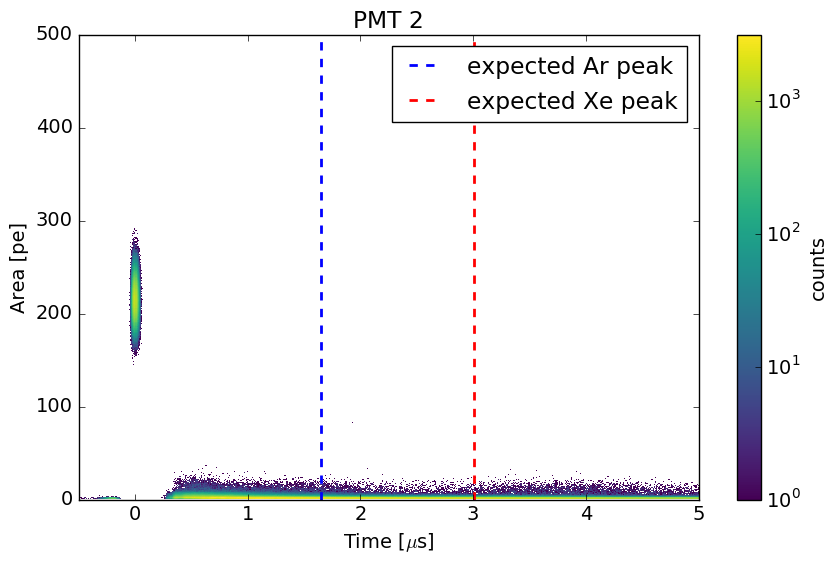

In [59]:
plot (AP_data, pmt, 1350)

In [27]:
from sklearn.mixture import GMM
from scipy.stats import norm

In [20]:
X=np.array([AP_data.area,AP_data.time])

In [34]:
X_re= X.reshape(len(AP_data),2)
print (X_re)

[[  2.05075406e+02   1.40811099e+00]
 [  4.71084612e-01   8.36912328e-01]
 [  1.79211009e+00   2.38045157e+00]
 ..., 
 [  3.96803358e+00   5.61803358e+00]
 [  6.34803358e+00  -1.19664225e-02]
 [  3.31803358e+00   4.54803358e+00]]


In [83]:
def compute_GMM(n_clusters, n_iter=1000, min_covar=3, covariance_type='full'):
    clf = GMM(n_clusters, covariance_type=covariance_type,
              n_iter=n_iter, min_covar=min_covar)
    clf.fit(X_re)
    print ("converged:", clf.converged_)
    return clf


#---------------- It's the correct way but it takes way too long! --------------------------

"""N = np.arange(17, 30)

def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print (N[i])
        models[i] = GMM(n_components=N[i], n_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X_re)
    return models

models = compute_GMM(N)
BIC = [m.bic(X_re) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]
print ("best fit converged:", gmm_best.converged_)
print ("BIC: n_components =  %i" % N[i_best]) """
#---------------------------------------------------------------

17
18
19
20
21
22
23
24
25
26
27
28
29
best fit converged: True
BIC: n_components =  29


In [97]:
# Compute a grid on which to evaluate the result
Nx = 550
Ny = 500
xmin, xmax = (-0.5, 5)
ymin, ymax = (0, 50)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

In [98]:
#clf = compute_GMM(n_clusters=100)



In [99]:
log_dens = clf.score(Xgrid).reshape(Ny, Nx)

(-1.0, 5.0, 0.0, 50.0)

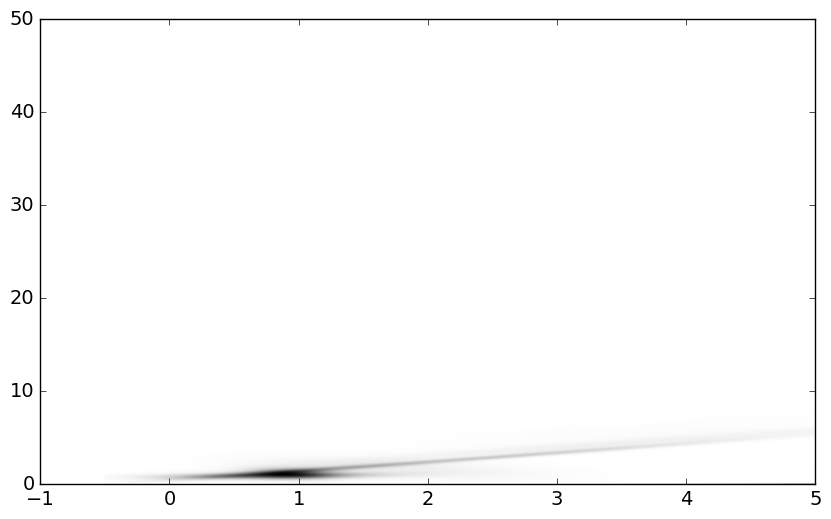

In [100]:
plt.figure(figsize=(10,6))
plt.imshow(np.exp(log_dens), origin='lower', cmap=plt.cm.binary,
          extent=[xmin, xmax,ymin, ymax])
plt.axis("auto")